# CNN Metastatic Cancer Detection

This project is part of a Kaggle competition where the task is to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset.

## Problem Description

The goal is to create an algorithm for identifying metastatic cancer in small image patches. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.

## Dataset

The dataset provided consists of a large number of small pathology images for classification. The `train_labels.csv` file provides the ground truth for the images in the train folder. The task is to predict the labels for the images in the test folder.



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
%matplotlib inline

!pip install torchsummary

## EDA

information file - train_labels.csv

In [2]:
labels_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(labels_df.head().to_markdown())

|    | id                                       |   label |
|---:|:-----------------------------------------|--------:|
|  0 | f38a6374c348f90b587e046aac6079959adf3835 |       0 |
|  1 | c18f2d887b7ae4f6742ee445113fa1aef383ed77 |       1 |
|  2 | 755db6279dae599ebb4d39a9123cce439965282d |       0 |
|  3 | bc3f0c64fb968ff4a8bd33af6971ecae77c75e08 |       0 |
|  4 | 068aba587a4950175d04c680d38943fd488d6a9d |       0 |


In [3]:
labels_df.shape

(220025, 2)

We know from the description that the data we use has no duplicated items.

In [4]:
labels_df[labels_df.duplicated(keep=False)]

Empty DataFrame
Columns: [id, label]
Index: []

In [5]:
labels_df['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

The dataset favored non-malignant normal cases (13,000 cases) over non-malignant cases (8.9,000 cases).

In [6]:
imgpath ="/kaggle/input/histopathologic-cancer-detection/train/"
malignant = labels_df.loc[labels_df['label']==1]['id'].values
normal = labels_df.loc[labels_df['label']==0]['id'].values

print('normal:', '\n', normal[0:3],'\n')

print('malignant:', '\n', malignant[0:3])

normal: 
 ['f38a6374c348f90b587e046aac6079959adf3835'
 '755db6279dae599ebb4d39a9123cce439965282d'
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08'] 

malignant: 
 ['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f']


### Data Visualization

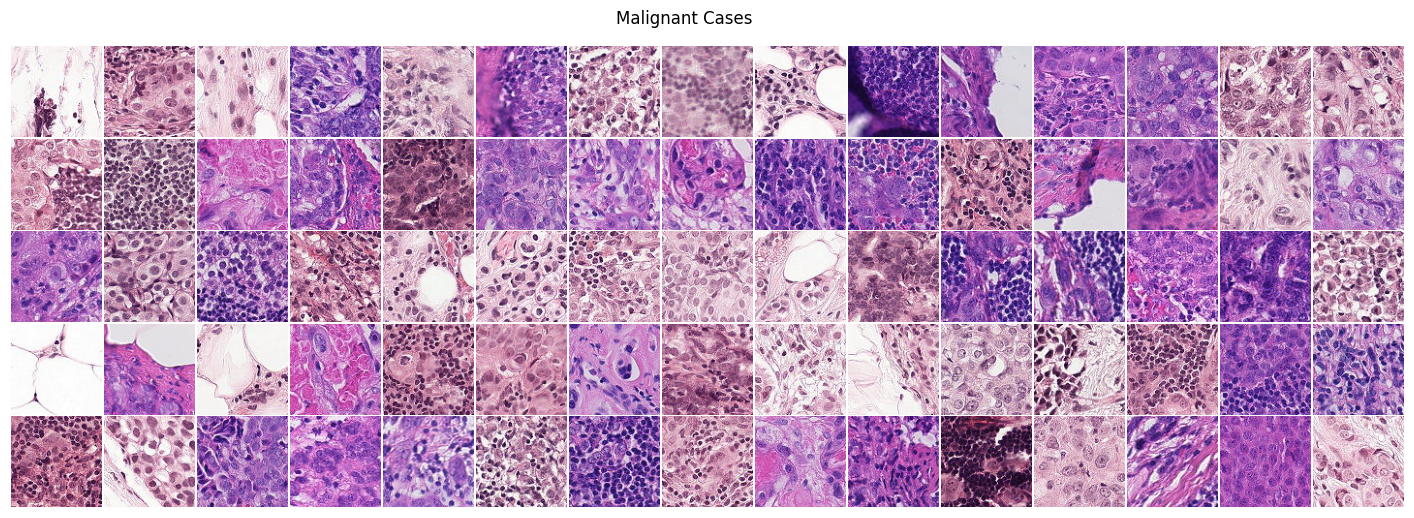

In [7]:
def plot_fig(ids,title,nrows=5,ncols=15):

    fig,ax = plt.subplots(nrows,ncols,figsize=(18,6))
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join(imgpath ,j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)

plot_fig(malignant,'Malignant Cases')

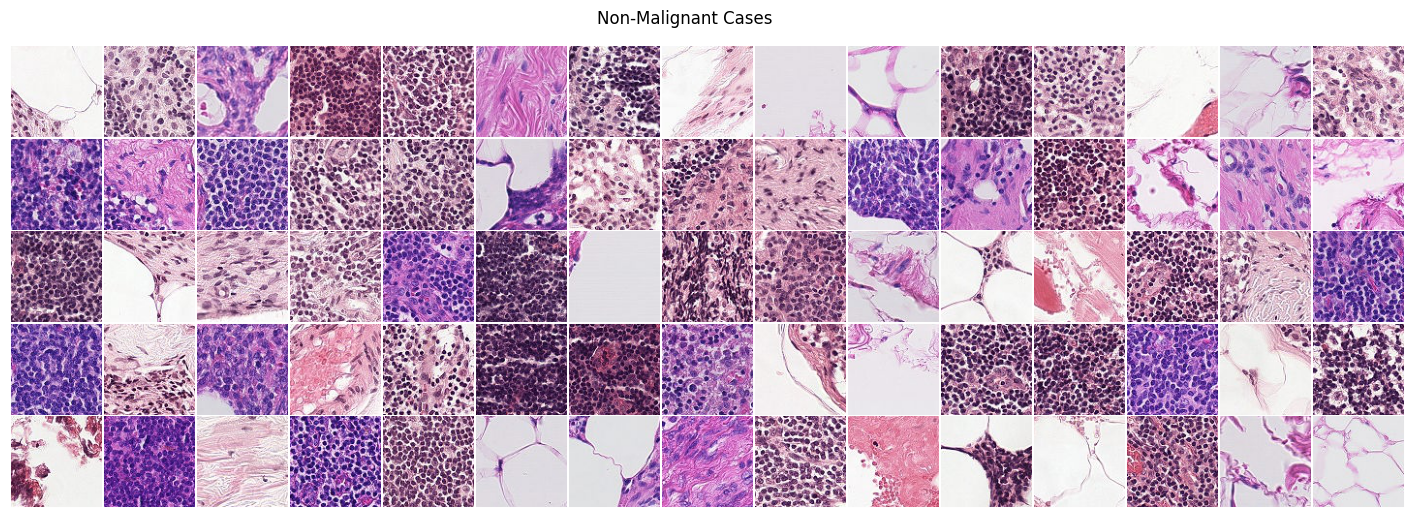

In [8]:
plot_fig(normal,'Non-Malignant Cases')

### Data Preparation

#### Data Formation

We can now change out data into a pytorch readable Dataset class inherited from Pytorch Dataset class:

In [9]:
torch.manual_seed(0)

class pytorch_data(Dataset):
    
    def __init__(self,data_dir,transform,data_type="train"):      
    
        # Get Image File Names
        cdm_data=os.path.join(data_dir,data_type)  # directory of files
        
        file_names = os.listdir(cdm_data) # get list of images in that directory  
#         self.full_filenames = [os.path.join(cdm_data, f) for f in file_names] 
        print("#File", len(file_names))
        idx_choose = np.random.choice(np.arange(len(file_names)), 
                                      220000,
#                                       4000,
                                      replace=False).tolist()
        file_names_sample = [file_names[x] for x in idx_choose]
        self.full_filenames = [os.path.join(cdm_data, f) for f in file_names_sample]   # get the full path to images
        
        # Get Labels
        labels_data=os.path.join(data_dir,"train_labels.csv") 
        labels_df=pd.read_csv(labels_data)
        labels_df.set_index("id", inplace=True) # set data frame index to id
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in file_names]  # obtained labels from df
        self.transform = transform
      
    def __len__(self):
        return len(self.full_filenames) # size of dataset
      
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # Open Image with PIL
        image = self.transform(image) # Apply Specific Transformation to Image
        return image, self.labels[idx]

PIL image

In [10]:
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((46,46), antialias=True)])

data_dir = '/kaggle/input/histopathologic-cancer-detection/'
img_dataset = pytorch_data(data_dir, data_transformer, "train") # Histopathalogic images

#File 220025


Tensor:

In [11]:
img,label=img_dataset[10]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 46, 46]) tensor(0.2983) tensor(0.9976)


#### Data Split

We'll perform an 80-20 split on training/validation.

In [12]:
len_img=len(img_dataset)
len_train=int(0.8*len_img)
len_val=len_img-len_train

# Split Pytorch tensor
train_ts,val_ts=random_split(img_dataset,
                             [len_train,len_val]) # random split 80/20

print("training set size:", len(train_ts))
print("validation set size:", len(val_ts))

ii=-1
for x,y in train_ts:
    print(x.shape,y)
    ii+=1
    if(ii>5):
        break

training set size: 3200
validation set size: 800
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 0


In [13]:
import plotly.express as px

def plot_img(x,y,title=None):

    npimg = x.numpy() # convert tensor to numpy array
    npimg_tr=np.transpose(npimg, (1,2,0)) # Convert to H*W*C shape
    fig = px.imshow(npimg_tr)
    fig.update_layout(template='plotly_white')
    fig.update_layout(title=title,height=300,margin={'l':10,'r':20,'b':10})
    fig.show()

#### Data Visualization 2

Let's have a look at the training set pics:

In [14]:
grid_size=30
rnd_inds=np.random.randint(0,len(train_ts),grid_size)
print("image indices:",rnd_inds)

x_grid_train=[train_ts[i][0] for i in rnd_inds]
y_grid_train=[train_ts[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=10, padding=2)
print(x_grid_train.shape)
    
plot_img(x_grid_train,y_grid_train,'Training Subset Examples')

image indices: [1858 1524 2167 2287 1601 3146  224  841 1237 2538 2151  924  761 1978
 1730  854 2085 2852 1292 1754 1282 2939 1785 2102  737 2760 2971 2855
  502 3061]
torch.Size([3, 146, 482])


And also validation set:

In [15]:
grid_size=30
rnd_inds=np.random.randint(0,len(val_ts),grid_size)
print("image indices:",rnd_inds)
x_grid_val=[val_ts[i][0] for i in range(grid_size)]
y_grid_val=[val_ts[i][1] for i in range(grid_size)]

x_grid_val=utils.make_grid(x_grid_val, nrow=10, padding=2)
print(x_grid_val.shape)

plot_img(x_grid_val,y_grid_val,'Validation Dataset Preview')

image indices: [175 506 247 270 443 471 379 281 357 733 415 342 244   1 252 202 454 481
 351 184 136 176 201 593 142 593  78  72 402 337]
torch.Size([3, 146, 482])


### Data Integration

When building deep learning models, pre-trained models, image transformations, and image enhancements are often considered an important part of the building process. By using image transformations, we can extend our dataset or resize and normalize it to achieve better model performance.

Typical transformations include horizontal flipping, vertical flipping, rotation and resizing. We can use a variety of image transformations for our binary classification model without changing the labels; we can flip/rotate a malignant image, but it will still be malignant.

In [16]:
# transformations for the training dataset
tr_transf = transforms.Compose([
#     transforms.Resize((40,40)),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),         
#     transforms.RandomResizedCrop(50,scale=(0.8,1.0),ratio=(1.0,1.0)),
    transforms.ToTensor()])

In [17]:
# As for the validation dataset, we don't need any augmentation; simply convert images into tensors
val_transf = transforms.Compose([
    transforms.ToTensor()])

# overwrite the train_ts, val_ts
train_ts.transform=tr_transf
val_ts.transform=val_transf

In [18]:
train_ts.transform

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
)

#### PyTorch Dataloader

In [19]:
from torch.utils.data import DataLoader

# Training Loader
train_dl = DataLoader(train_ts,
                      batch_size=32, 
                      shuffle=True)

# Validation Loader
val_dl = DataLoader(val_ts,
                    batch_size=32,
                    shuffle=False)

In [20]:
# test
for x,y in train_dl:
    print(x.shape,y)
    break

torch.Size([32, 3, 46, 46]) tensor([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 1])


## Model Building

### Binary Classifier

- **Four CNN Conv2D layers**: a pooling layer (max_pool2D) is added between each of these layers.
- **Two fully connected layers (fc)**: a dropout layer is added between these two layers to prevent overfitting.
- **Activation function**: we used log_softmax as the activation function in the last layer of the binary classifier.

In [21]:
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

import torch.nn as nn
import torch.nn.functional as F

# Neural Network
class Network(nn.Module):
    def __init__(self, params):
        
        super(Network, self).__init__()
    
        Cin,Hin,Win=params["shape_in"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        
        X = F.relu(self.conv1(X)); 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)

        X = X.view(-1, self.num_flatten)
        
        X = F.relu(self.fc1(X))
        X=F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

### CNN Modeling

In [22]:
params_model={
        "shape_in": (3,46,46), 
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

cnn_model = Network(params_model)

# CUDA or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = cnn_model.to(device)

from torchsummary import summary
summary(cnn_model, input_size=(3, 46, 46),device=device.type)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 44, 44]             224
            Conv2d-2           [-1, 16, 20, 20]           1,168
            Conv2d-3             [-1, 32, 8, 8]           4,640
            Conv2d-4             [-1, 64, 2, 2]          18,496
            Linear-5                  [-1, 100]           6,500
            Linear-6                    [-1, 2]             202
Total params: 31,230
Trainable params: 31,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.19
Params size (MB): 0.12
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


### Loss Function

For binary classification tasks, we can opt for one or two outputs. It’s recommended to use log_softmax as it’s easily expandable to multiclass classification. PyTorch combines the log and softmax operations into a single function for numerical stability and speed.

In [23]:
loss_func = nn.NLLLoss(reduction="sum")

### Optimiser

The optimizer will maintain the current state and update the parameters based on the calculated gradient.

For binary classification tasks, commonly used optimizers include SGD and Adam, and we choose to use the latter here. This is an ongoing process where the goal is to minimize the value of the loss function and thus improve the predictive performance of the model.

In [24]:
from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

## Training

In [25]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) 
    pred = output.argmax(dim=1, keepdim=True) 
    metric_b=pred.eq(target.view_as(pred)).sum().item() 
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) 
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) 
        run_loss+=loss_b    

        if metric_b is not None:
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data) 
    metric=t_metric/float(len_data) 
    
    return loss, metric

params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 50,
 "optimiser": optim.Adam(cnn_model.parameters(),
                         lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
 "check": False, 
}

from tqdm.notebook import trange, tqdm

def train_val(model, params,verbose=False):
    
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    loss_history={"train": [],"val": []} # history of loss in each epoch
    metric_history={"train": [],"val": []} # histroy of metrics in each epoch
    best_model_wts = copy.deepcopy(model.state_dict()) # deep copy of weights
    best_loss=float('inf')
    
    # Train n_epochs 
    
    for epoch in tqdm(range(epochs)):
        
        # Learning Rate
        current_lr=get_lr(opt)
        if(verbose):
            print('Ep {}/{}, lr={}'.format(epoch, epochs - 1, current_lr))
        
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        # store best
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # load best weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [26]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 50,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

# train and validate
cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

  0%|          | 0/50 [00:00<?, ?it/s]

#### Evaluation

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version

Text(0.5, 1.0, 'Convergence History')

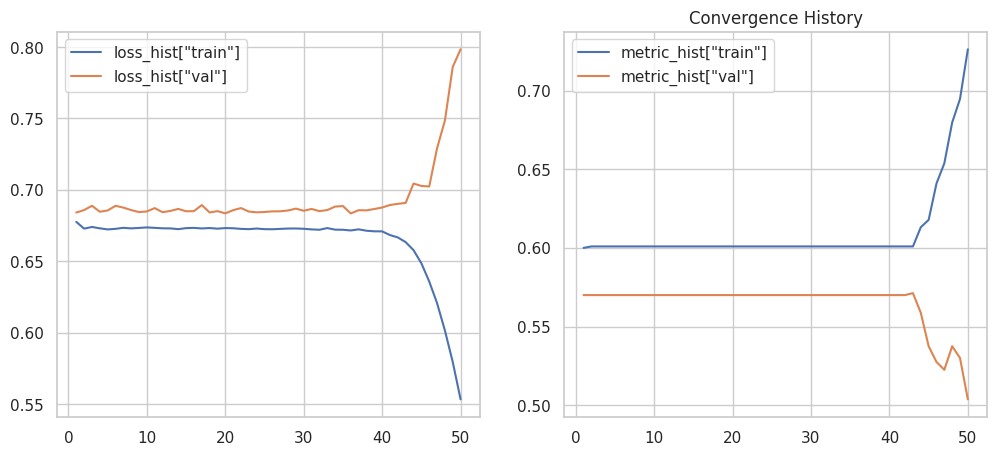

In [27]:
import seaborn as sns; sns.set(style='whitegrid')

epochs=params_train["epochs"]

fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='metric_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='metric_hist["val"]')
plt.title('Convergence History')

In [28]:
class pytorchdata_test(Dataset):
    
    def __init__(self, data_dir, transform,data_type="train"):
        
        path2data = os.path.join(data_dir,data_type)
        filenames = os.listdir(path2data)
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        
        # labels are in a csv file named train_labels.csv
        csv_filename="sample_submission.csv"
        path2csvLabels=os.path.join(data_dir,csv_filename)
        labels_df=pd.read_csv(path2csvLabels)
        
        # set data frame index to id
        labels_df.set_index("id", inplace=True)
        
        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
        self.transform = transform       
        
    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx]) # PIL image
        image = self.transform(image)
        return image, self.labels[idx]
    


In [29]:
path_sub = "/kaggle/input/histopathologic-cancer-detection/sample_submission.csv"
labels_df = pd.read_csv(path_sub)
labels_df.head()
labels_df.shape

(57458, 2)

check saved weight files

In [30]:
!ls

weights.pt


In [31]:
!ls '/kaggle/input/histopathologic-cancer-detection/test' | head -n 5

00006537328c33e284c973d7b39d340809f7271b.tif
0000ec92553fda4ce39889f9226ace43cae3364e.tif
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
000270442cc15af719583a8172c87cd2bd9c7746.tif
ls: write error: Broken pipe


we can load model weights

In [32]:
cnn_model.load_state_dict(torch.load('weights.pt'))

<All keys matched successfully>

### Test

In [33]:
data_dir = '/kaggle/input/histopathologic-cancer-detection/'

data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((46,46))])

img_dataset_test = pytorchdata_test(data_dir,data_transformer,data_type="test")
print(len(img_dataset_test), 'samples found')

57458 samples found


### Prediction/Results

In [34]:
def inference(model,dataset,device,num_classes=2):
    
    len_data=len(dataset)
    y_out=torch.zeros(len_data,num_classes) # initialize output tensor on CPU
    y_gt=np.zeros((len_data),dtype="uint8") # initialize ground truth on CPU
    model=model.to(device) # move model to device
    
    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y=dataset[i]
            y_gt[i]=y
            y_out[i]=model(x.unsqueeze(0).to(device))

    return y_out.numpy(),y_gt    

In [35]:
y_test_out,_ = inference(cnn_model,img_dataset_test, device) 

print(y_test_out.shape)
print(y_test_out[0:5])

  0%|          | 0/57458 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning:

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).



(57458, 2)
[[-0.5424417  -0.87066543]
 [-0.52381754 -0.89711404]
 [-0.5222285  -0.8994267 ]
 [-0.5344     -0.88193965]
 [-0.5055952  -0.92418796]]


In [36]:
y_test_pred=np.argmax(y_test_out,axis=1)
print(y_test_pred.shape)
print(y_test_pred[0:5])

(57458,)
[0 0 0 0 0]


In [37]:
preds = np.exp(y_test_out[:, 1])
print(preds.shape)
print(preds[0:5])

(57458,)
[0.41867286 0.4077447  0.40680283 0.41397917 0.39685354]


## Output

In [38]:
submission_df = pd.DataFrame({
    'id': [fname.split('/')[-1].split('.')[0] for fname in img_dataset_test.full_filenames],
    'label': preds
})


submission_df.to_csv('CNN_submission.csv', index=False)

## Conclusion 

In this project, I gained insight into how to utilize Convolutional Neural Networks (CNN) for cancer detection in medical images. Here are some notable takeaways:

- Data processing challenges: managing large datasets can be challenging. I explored various efficient data loading methods, such as converting images to int8 numpy arrays. However, this approach proved to be memory intensive and impacted model training.
- Impact of Migration Learning: employing migration learning significantly increases the complexity of the model. In addition, migration learning models are typically trained on more diverse and larger datasets, and this injection of external knowledge allows the model to recognize complex patterns in medical images. Moreover, migration learning can simultaneously address the overfitting problem.
- Model Evaluation Considerations: while AUC is a powerful metric, it introduces complexity in the model compilation process because it considers the performance of all thresholds. In contrast, practical evaluation metrics, such as recall, precision, and confusion matrices, typically rely on fixed thresholds, usually set at 0.5.

Future improvements:

- Exploring alternative metrics: experimenting with alternative metrics, such as accuracy, may provide a different perspective on model performance. However, achieving a balanced dataset is crucial in this case.
- Optimize regions of interest: focusing on the central 32x32 region, which is the most relevant for cancer detection, may involve cropping the image to improve the efficiency and effectiveness of the model.
- Address differences in test AUCs:
 + Try adding enhancement and dropout techniques to reduce overfitting.
 + Consider expanding the size of the validation set to more representatively assess the model's ability to generalize.
